## MLFlow avec TensorFlow 2.0



In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import roc_auc_score
import mlflow
import mlflow.tensorflow
print("TensorFlow: {}".format(tf.__version__))
print("Scikit-Learn: {}".format(sklearn.__version__))
print("Numpy: {}".format(np.__version__))
print("MLFlow: {}".format(mlflow.__version__))
print("Matplotlib: {}".format(matplotlib.__version__))

2025-11-16 15:30:13.614998: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-16 15:30:13.635369: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-16 15:30:14.216027: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-16 15:30:16.540618: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

TensorFlow: 2.20.0
Scikit-Learn: 1.7.2
Numpy: 2.3.4
MLFlow: 3.6.0
Matplotlib: 3.10.7


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Class:  5


(<matplotlib.image.AxesImage at 0x7f6ffe317230>, None)

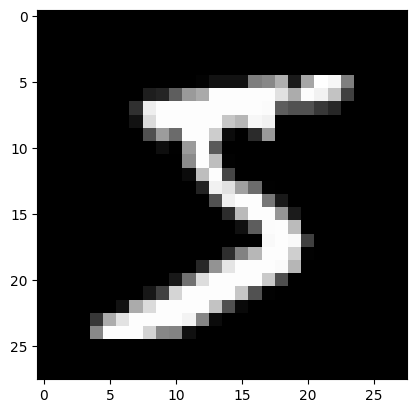

In [3]:
# pour avoir un aperçu sur le dataset
plt.imshow(x_train[0], cmap='gray'), print("Class: ", y_train[0])

Notez également que les étiquettes sont toutes des nombres entiers compris entre 0 et 9, chacune associée à une image qui montre un chiffre manuscrit de 0 à 9. 

Étant donné que les couches convolutives 2D dans TensorFlow/Keras s'attendent à quatre dimensions au format (m, h, w, c) où m représente le nombre d'échantillons dans l'ensemble de données, h et w représentent respectivement la hauteur et la largeur, et c représente le nombre de canaux (trois s'il s'agit d'une image couleur RGB par exemple), vous devez remodeler vos données afin qu'elles soient conformes à ces spécifications. Vos images sont toutes en noir et blanc, elles en ont donc techniquement 1 canal. Et donc, vous devez les remodeler comme ceci : 

In [4]:
y_train[0]

np.uint8(5)

In [5]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1],
x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1],
x_test.shape[2], 1)
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [6]:
y_train[0] # this is a one-hot encoded vector, ntice that at index 5 the value is 5

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [7]:
print("Shapes")
print("x_train: {}\ny_train: {}".format(x_train.shape,
y_train.shape))
print("x_test: {}\ny_test: {}".format(x_test.shape,
y_test.shape))

Shapes
x_train: (60000, 28, 28, 1)
y_train: (60000, 10)
x_test: (10000, 28, 28, 1)
y_test: (10000, 10)


### MLFlow run - training and evaluating 

Nous allons créer notre modèle en utilisant la méthode séquentielle de création de modèle. Le modèle sera assez simple,
composé de quelques couches convolutives 2D qui alimentent trois couches denses. 

In [8]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=3, strides=2,padding='same', input_shape=(28, 28, 1), activation="relu"))
model.add(Conv2D(filters=8, kernel_size=3, strides=2,padding='same', input_shape=(28, 28, 1), activation="relu"))
model.add(Flatten())
model.add(Dense(30, activation="relu"))
model.add(Dense(20, activation="relu"))
model.add(Dense(10, activation="softmax"))
model.summary()

/home/zczak/LAB_CLOUD_COMPUTING_M311/Lab Folder MLOps/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-11-16 15:31:15.322311: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 8)        │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 392)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │        11,790 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,940 (54.45 KB)

 Trainable params: 13,940 (54.45 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# nous allons compiler notre modèle en utilisant adam optimizer 
model.compile(optimizer="Adam",loss="categorical_crossentropy", metrics=["accuracy"])

Nous allons maintenant dire à MLFlow de loger ce run. nous souhaitons que toutes les métriques soient enregistrées dans la même exécution, vous devez donc indiquer spécifiquement à MLFlow d'exécuter un bloc de code dans le contexte de la même exécution. 

In [10]:
mlflow.set_experiment("TF_Keras_MNIST")
with mlflow.start_run():
    mlflow.tensorflow.autolog()
    model.fit(x=x_train, y=y_train, batch_size=256, epochs=10)
    preds = model.predict(x_test)
    preds = np.round(preds)
    eval_acc = model.evaluate(x_test, y_test)[1]
    auc_score = roc_auc_score(y_test, preds)
    print("eval_acc: ", eval_acc)
    print("auc_score: ", auc_score)
    mlflow.tensorflow.mlflow.log_metric("eval_acc", eval_acc)
    mlflow.tensorflow.mlflow.log_metric("auc_score", auc_score)
mlflow.end_run()

/home/zczak/LAB_CLOUD_COMPUTING_M311/Lab Folder MLOps/venv/lib/python3.12/site-packages/mlflow/tracking/_tracking_service/utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)


Epoch 1/10
227/235 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4300 - loss: 2.4473

2025/11/16 15:31:44 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6561 - loss: 1.2163
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9058 - loss: 0.3285

2025/11/16 15:31:45 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9204 - loss: 0.2800
Epoch 3/10
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9500 - loss: 0.1696

2025/11/16 15:31:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9523 - loss: 0.1642
Epoch 4/10
232/235 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9657 - loss: 0.1168

2025/11/16 15:31:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9649 - loss: 0.1189
Epoch 5/10
231/235 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9725 - loss: 0.0924

2025/11/16 15:31:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9716 - loss: 0.0946
Epoch 6/10
231/235 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9769 - loss: 0.0743

2025/11/16 15:31:53 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9762 - loss: 0.0782
Epoch 7/10
231/235 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9807 - loss: 0.0644

2025/11/16 15:31:54 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9801 - loss: 0.0651
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9837 - loss: 0.0535

2025/11/16 15:31:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9827 - loss: 0.0566
Epoch 9/10
228/235 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9848 - loss: 0.0495

2025/11/16 15:31:57 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9843 - loss: 0.0496
Epoch 10/10
228/235 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9865 - loss: 0.0452

2025/11/16 15:31:58 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9862 - loss: 0.0451


2025/11/16 15:31:58 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: tuple index out of range
2025/11/16 15:31:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/16 15:31:58 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/11/16 15:32:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9775 - loss: 0.0798
eval_acc:  0.9775000214576721
auc_score:  0.9868482271270201


la ligne mlflow.keras.autolog() 

Cela indique essentiellement à MLFlow d'enregistrer tous les paramètres et métriques associés au modèle TensorFlow/Keras. Comme vous le verrez dans peu de temps, MLFlow enregistrera les hyperparamètres, les métriques du modèle répertoriées dans la fonction compile() et même le modèle lui-même une fois l'entraînement terminé. 

### MLFlow UI 

ouvrons maintenant l'interface utilisateur de MLFlow et vérifions notre run. Assurez-vous que votre terminal ou invite de commande se trouve dans le même répertoire que celui où les mlruns sont stockés.

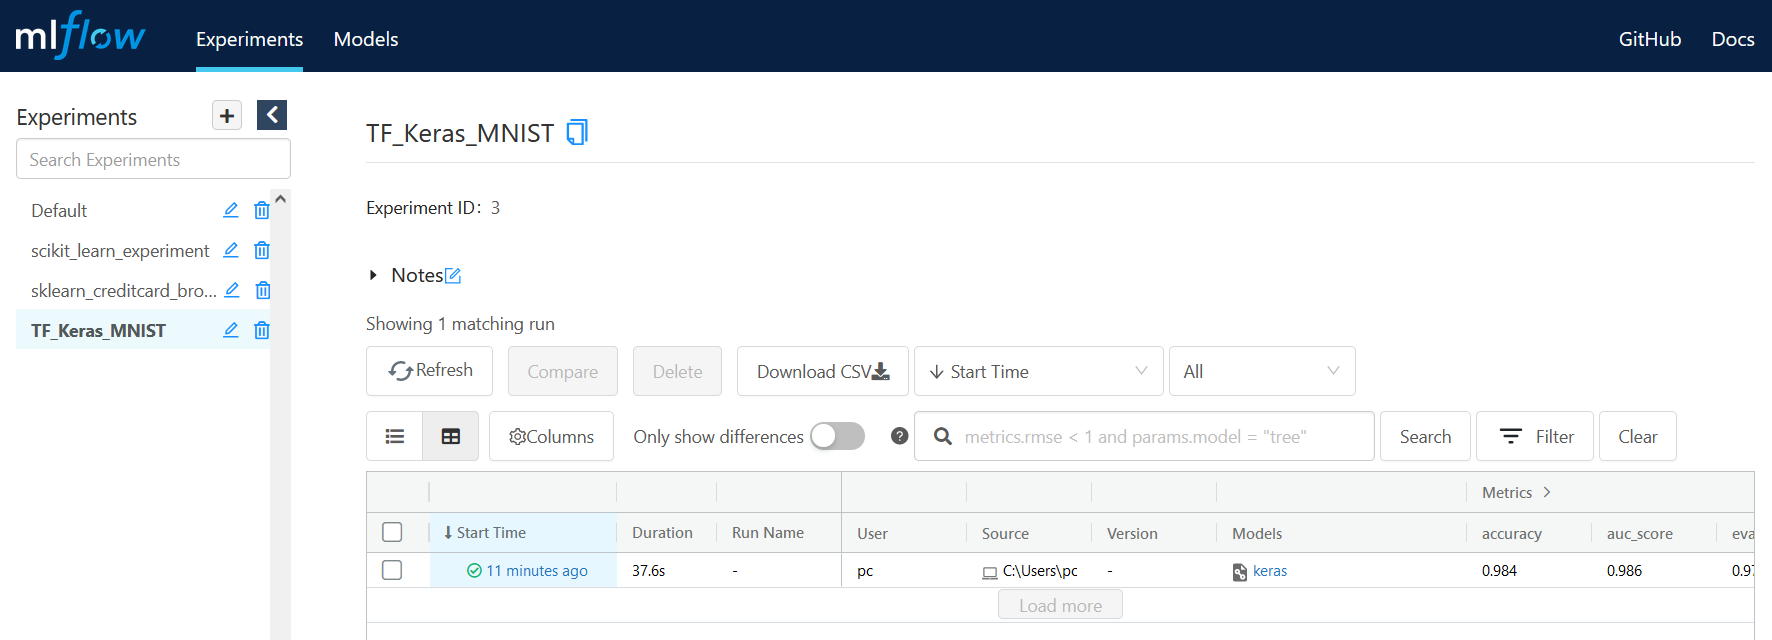

En cliquant sur le run, vous allez remarqué que MLFlow a enregistré tous les hyperparamètres utilisés lors de la création du modèle. Cela peut être très utile pour le réglage des hyperparamètres sur un ensemble de validation, par exemple, lorsque vous essayez de régler plusieurs hyperparamètres à la fois. Par exemple, vous pouvez certainement régler batch_size, epochs ou quelque chose lié à l'optimiseur Adam comme opt_learning_rate, opt_beta_1 ou opt_beta_2. 

Dans la partie artifacts en bas, vous allez remqrquer que MLflow a enregistré le modèle aussi, l'évnement Tensorboard et le summary du modèle 

### Model loading 

copiez l'ID du run 

In [12]:
loaded_model = mlflow.tensorflow.load_model("runs:/1c9974ff6f064bbf9207183dcff774b4/model")

Vous remarquerez que nous avons fait mlflow.keras au lieu de mlflow.tensorflow. C'est parce que ce modèle est techniquement un modèle Keras, et donc il est conforme au code load_model() spécifique dans le module mlflow.keras. 

In [13]:
eval_loss, eval_acc = loaded_model.evaluate(x_test, y_test)
preds = loaded_model.predict(x_test)
preds = np.round(preds)
eval_auc = roc_auc_score(y_test, preds)
print("Eval Loss:", eval_loss)
print("Eval Acc:", eval_acc)
print("Eval AUC:", eval_auc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9775 - loss: 0.0798
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Eval Loss: 0.07981005311012268
Eval Acc: 0.9775000214576721
Eval AUC: 0.9868482271270201


Comme vous pouvez le voir, cette sortie correspond aux valeurs de la sortie de l'exécution précédente. De plus, ce modèle est également fonctionnel et peut faire des prédictions. 